In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import random
import scipy.optimize
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
#from IPython import display, HTML
#display(HTML("<style>div.output_scroll { height: 50em; }</style>"))
%matplotlib inline
    
def runSim(T0i, endTime, output, hAoverCth):
    time_S = [] #time_S list
    #Temperatures in Kelvin
    temp_S = [T0i] #Average block temp under heater
    gradient_S = [0] #Change in temperature over time_S
    i = 0
    while True:
        if len(time_S) == 0:
            time_S.append(0.0)
        else:
            time_S.append(round(time_S[-1]+dt,6)) #base 10 rounding avoids accumulated rounding errors from python
        DeltaTemp_S =  hAoverCth * (fitFinalTemp(output, TK0, rate) - temp_S[-1]) * dt
        temp_S.append(temp_S[-1] + DeltaTemp_S)
 
        if len(temp_S) >= 2:
            gradient_S.append((temp_S[-1] - temp_S[-2]) / dt)
        if ((time_S[-1].is_integer() == True) and (int(time_S[-1]) % 60 == 0)):
            #print simulation time
            hours = int(time_S[-1]//(60*60))
            minutes = int(time_S[-1]/60 - hours * 60)
            if minutes < 10:
                minutes = str(0) + str(minutes)
            if hours < 10:
                hours = str(0) + str(hours)
            timeStamp = str(hours) + ':' + str(minutes)
            #print(timeStamp, end='\r')
        if time_S[-1] >= endTime:
            break
    result_S = [time_S, temp_S, gradient_S]
    return result_S

def readFile(filename):
    data = []
    with open(filename) as csvfile: 
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            row=[i for i in row if i] # remove empty spaces from row
            data.append(row)
        #print(data[0])
        data.pop(0)
    return data

def fo(t, K, taui, y0=0):
    #https://github.com/alchemyst/Dynamics-and-Control/blob/master/tbcontrol/responses.py
    # First Order response with bias
    return y0 + np.sign(K)*np.maximum(0, abs(K)*(1 - np.exp(-(t - np.min(t))/taui)))
    #return y0 + K*(1 - np.exp(-(t - np.min(t))/taui))

def fitFinalTemp(output, TF0, rate):
    return TF0 + np.exp(output/rate)

def getTimeTempE(outputList, results_E):
    for j in range(0, len(outputList)):
        resultArrs_E = np.array(results_E[j]).T
        timeList_E = resultArrs_E[0]
        tempList_E = resultArrs_E[1]
        timeList_E = list(map(float, timeList_E))
        tempList_E = list(map(float, tempList_E))
        time_E.append(np.array(timeList_E) - timeList_E[0])
        temp_E.append(np.array(tempList_E))
    return time_E, temp_E

def compare(hAoverCth):
    #diffRMS = []
    percentDiffRMS = []
    tempFitSPoints = []
    percentDiff = []
    for i in range(0, len(outputList)):
        #results_S = runSim(T0[i], time_E[i][-1], finalTemp[i], hAoverCth)
        results_S = runSim(T0[i], time_E[i][-1], outputList[i], hAoverCth)
        tempFitSPoints = fo(results_S[0], T_K[i], tau[i], T0[i])
        #diffRMS.append(np.mean(np.square(np.array(results_S[1][:-1]) - np.array(tempFitSPoints))))
        #percentDiffRMS.append(100 * np.sqrt(np.mean(np.square((np.array(results_S[1][:-1]) - np.array(tempFitSPoints))\
        #                                                      /(0.5*(np.array(results_S[1][:-1]) + np.array(tempFitSPoints)))))))
        for j in range(0, len(results_S[1][:-1])):
            percentDiff.append(100*(np.array(results_S[1][j]) - np.array(tempFitSPoints[j]))\
                               /(0.5*(np.array(results_S[1][j]) + np.array(tempFitSPoints[j]))))
    #totalDiff = np.sum(diffRMS)
    #avgPercentDiff = np.average(percentDiffRMS)
    #return totalDiff 
    percentDiffRMS = np.sqrt(np.mean(np.square(percentDiff)))
    return percentDiffRMS

T_f:  106.48112798526483 a:  16.66040204370146
R^2 value:  0.9994623422842251


[]

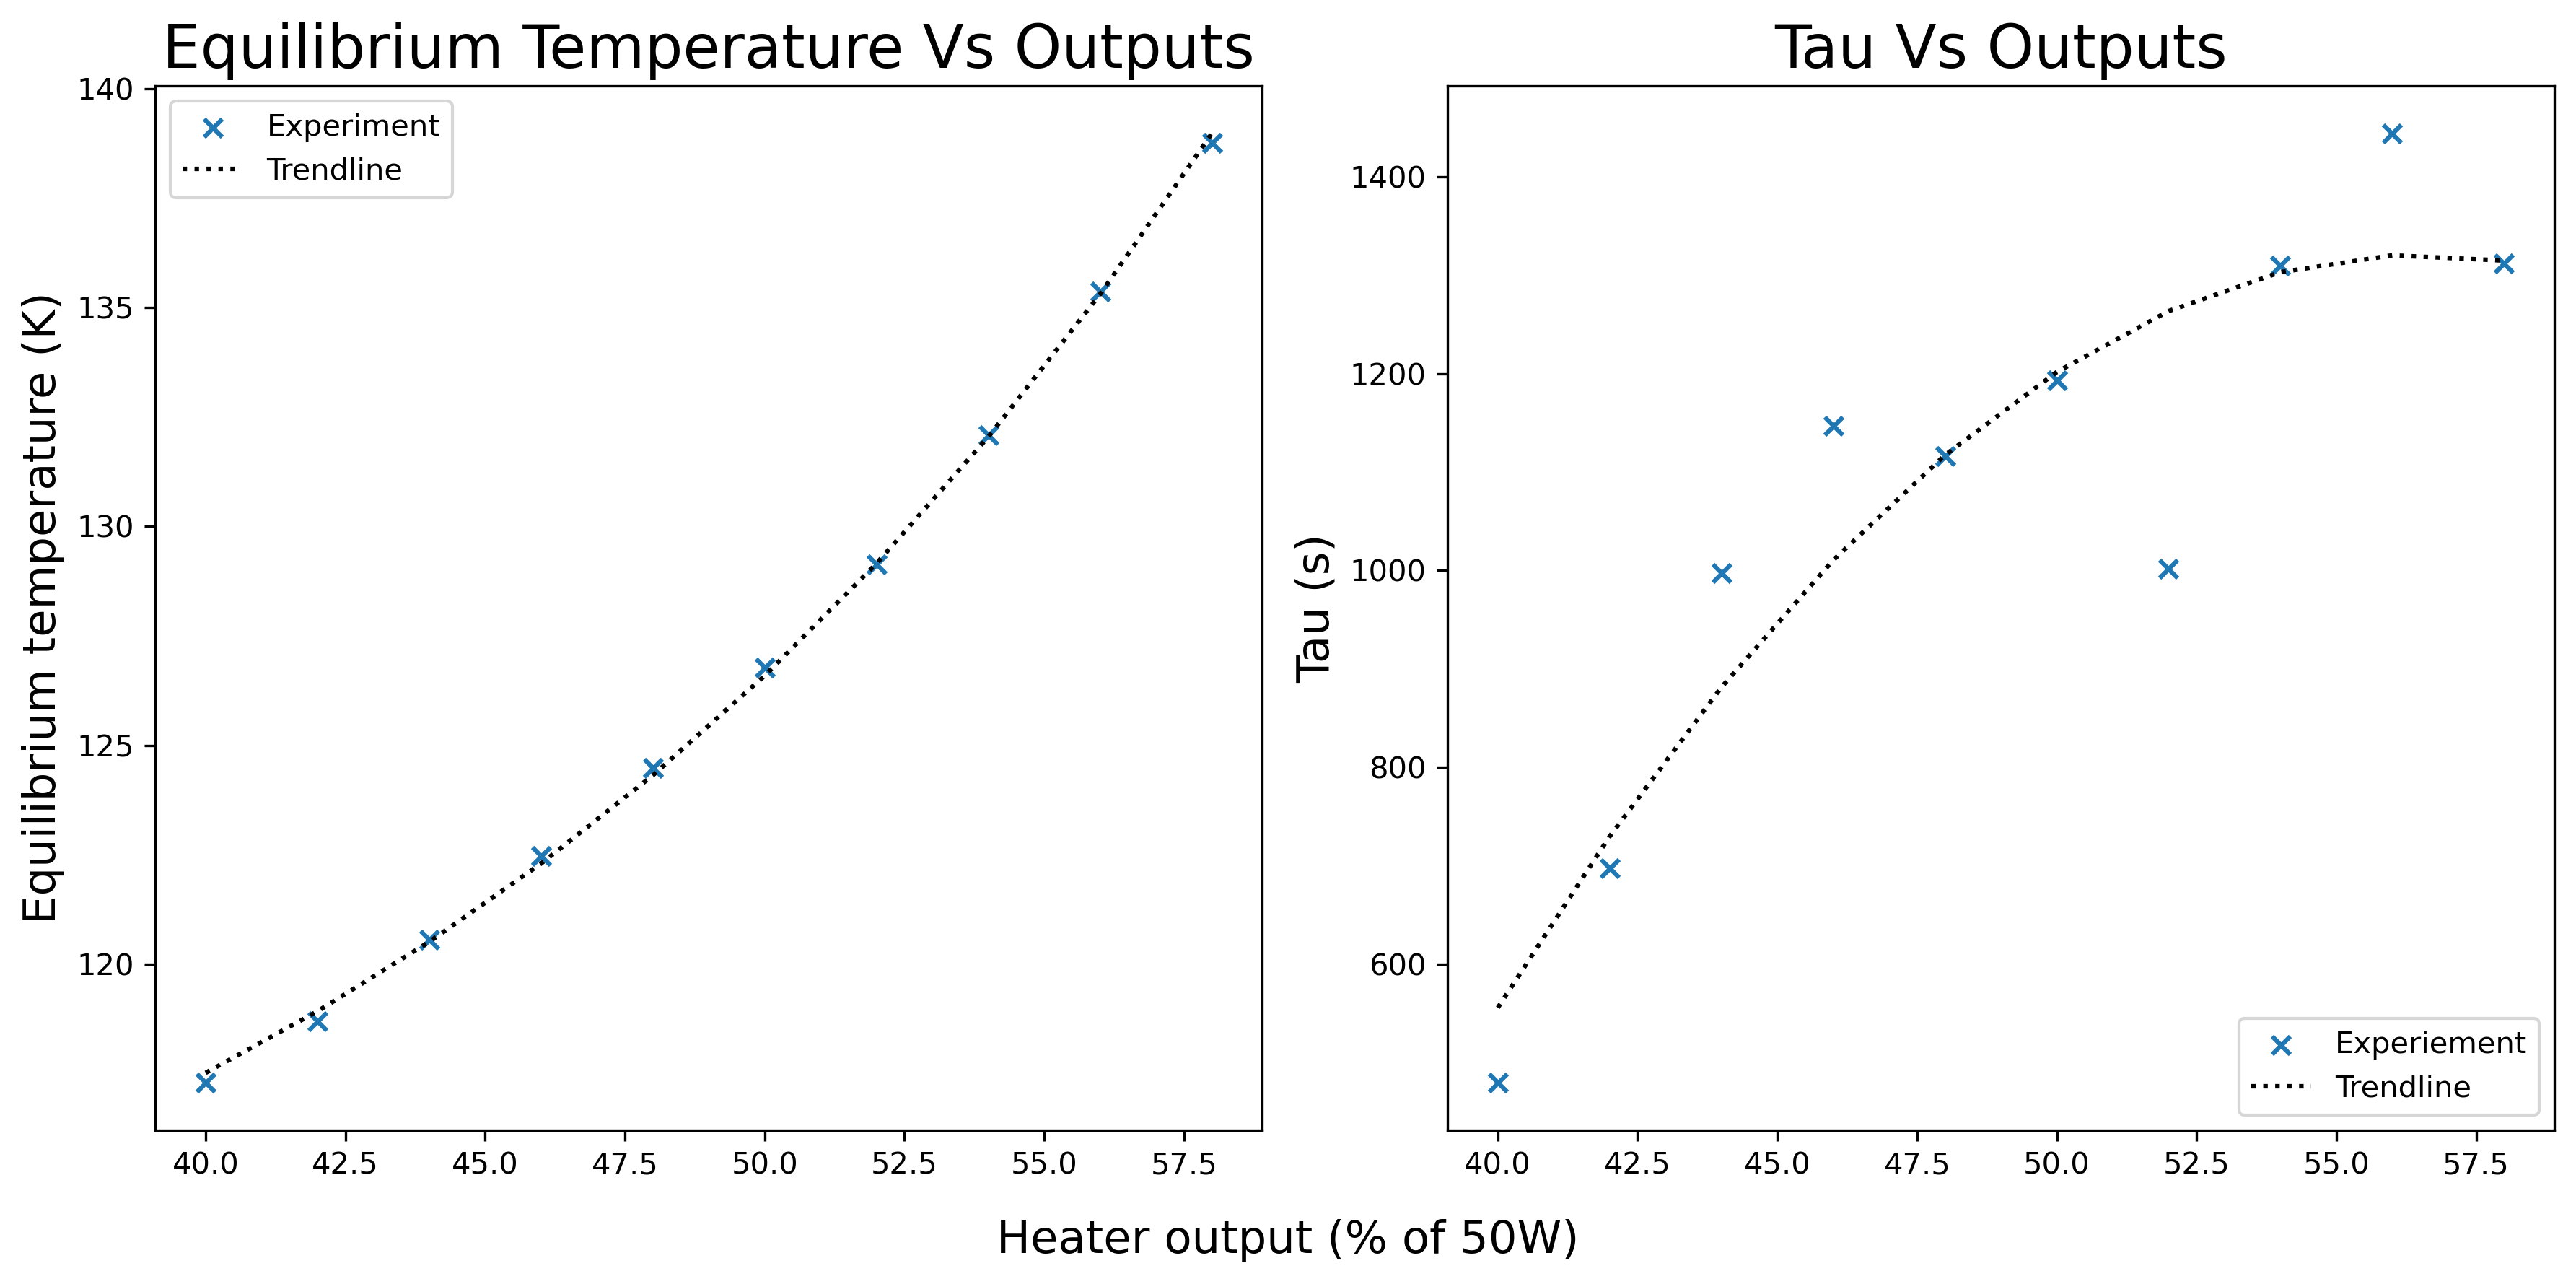

In [7]:
#Expermental data
run = '10' #which no. run to analyse
path = 'Results/' #path of file
runfile = 'tuningDataNB' + str(run) + '.csv'
#runfile = 'RelayTuning3.csv'
pathRunfile = path + runfile
dataList_E = readFile(pathRunfile)
#outputSet_E = set()
outputList = []
results_E = []
result_E = []
time_E = []
temp_E = []
resultArrs_E = []
gradients_E = []
#add the first row to the new result
result_E.append([dataList_E[0][0], dataList_E[0][1]])
#Add the new output to the list of outputs for this run
outputList.append(float(dataList_E[0][2]))
#for every row in data
for i in range(0, len(dataList_E)):
    if float(dataList_E[i][2]) == outputList[-1]:
        #add row to result
        result_E.append([dataList_E[i][0], dataList_E[i][1]])
    else:
        #add result to results
        if len(result_E) > 0:
            results_E.append(result_E)
        result_E = [] #reset result list
        #add row to result
        result_E.append([dataList_E[i][0], dataList_E[i][1]])
        #outputSet_E.add(dataList_E[i][2]) #add output to output set
        outputList.append(float(dataList_E[i][2]))
results_E.append(result_E)
time_E, temp_E = getTimeTempE(outputList, results_E)

T_K=[]; tau=[]; T0=[]
tempFitstddev = []
tempFit_E = []
for i in range(0, len(outputList)): 
    [T_Ki, taui, T0i], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i], p0=[0,600,100])
                                                    #p0=[0, 1000, temp_E[i][0]], 
                                                    #bounds=((-np.inf,0,temp_E[i][0]-0.1),  
                                                    #        (np.inf,np.inf,temp_E[i][0]+0.1)))
    T_K.append(T_Ki)
    tau.append(taui)
    T0.append(T0i)
    #tempFit_E.append(fo(time_E[i], T_K[i], tau[i], T0[i]))
    poptTempFit, pcovTempFit = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i], p0=[0, 600, 100])#, sigma=sig, absolute_sigma=True)
    tempFit_E.append(fo(time_E[i], *poptTempFit))
    avgDiff = np.sum(tempFit_E[i] - temp_E[i])/len(temp_E[i])
    tempFitcovsum = 0
    for j in range(0 , len(tempFit_E[i])):
        tempFitcovsum += (tempFit_E[i][j] - temp_E[i][j] - avgDiff)**2
    tempFitstddev.append((tempFitcovsum/len(tempFit_E[i]))**0.5)
    #print(i, tempFitstddev[i])
    
T_KFit = np.poly1d(np.polyfit(outputList, T_K, 2))
tauFit = np.poly1d(np.polyfit(outputList, tau, 2))
finalTemp = np.array(T_K) + np.array(T0)
finalTempFit = np.poly1d(np.polyfit(outputList, finalTemp, 2))
#logOutputList = np.log(outputList[1:])
#finalTempLogFit = np.poly1d(np.polyfit(logOutputList, finalTemp[1:], 1))
[TK0, rate], _ = scipy.optimize.curve_fit(fitFinalTemp, outputList, finalTemp)
print('T_f: ', TK0, 'a: ', rate)

finalTempLogFit = fitFinalTemp(outputList, TK0, rate)
finalTempLogFit_R2 = r2_score(finalTemp, fitFinalTemp(outputList, TK0, rate))
finalTempError = [3*np.array(tempFitstddev),3*np.array(tempFitstddev)]
#print(finalTempError)
print('R^2 value: ', finalTempLogFit_R2)

fig2, ax2 = plt.subplots(1, 2, figsize=(12,6), dpi=300)
ax2[0].set_title('Equilibrium Temperature Vs Outputs', fontsize=20)
fig2.supxlabel('Heater output (% of 50W)', fontsize=15, y=0.02)
ax2[0].set_ylabel('Equilibrium temperature (K)', fontsize=15)
ax2[0].scatter(outputList, finalTemp, marker='x', label='Experiment')
ax2[0].plot(outputList, finalTempLogFit, linestyle=':', label='Trendline', color='black')
#ax1[1].errorbar(outputList, finalTemp, yerr=finalTempError, fmt='none')
ax2[0].legend()
ax2[1].set_title('Tau Vs Outputs', fontsize=20)
ax2[1].set_ylabel('Tau (s)', fontsize=15)
ax2[1].scatter(outputList, tau, marker='x', 
               label='Experiement')
ax2[1].plot(outputList, tauFit(outputList), linestyle=':', 
           label='Trendline', color='black')
ax2[1].legend(loc='lower right')
plt.tight_layout()
plt.plot()

In [12]:
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.set_title('Temperature Gain Vs Outputs')
ax1.set_xlabel('Output (%)')
ax1.set_ylabel('Gain Temperature (K)')
ax1.scatter(outputList, T_K, marker='x', label='Experiment')
ax1.legend()

dt=0.1
totalDiff = float('inf')
counter = 1
hAoverCth_Vals = np.linspace(0.00075, 0.00095, 6)
for hAoverCth in hAoverCth_Vals:
    totalDiffNew = compare(hAoverCth)
    if totalDiffNew < totalDiff:
        totalDiff = totalDiffNew
        best_param = hAoverCth
    print(counter, hAoverCth, totalDiffNew)
    counter += 1
print('best: ', best_param, totalDiff)
hAoverCth = best_param

1 0.00075 0.4887395611273844
2 0.00079 0.48878179978953684
3 0.00083 0.4896825026303797
4 0.00087 0.49126653568519146
5 0.00091 0.49339067354125166
6 0.00095 0.4959380238270005
best:  0.00075 0.4887395611273844


In [ ]:
fig3, ax3 = plt.subplots(figsize=(8,10), dpi=300)
ax3 = plt.gca()
ax3.set_title('Temperature Vs Time')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Temperature (K)')
results_S = []
colors = sns.color_palette('hls', len(outputList))
ax3.set_prop_cycle('color', colors)
for i in range(0, len(outputList)):
    #[T_Ki, taui, T0i], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i])
    #tempFit_E.append(fo(time_E[i], T_K[i], tau[i], T0[i])) 
    #results_S.append(runSim(T0[i], time_E[i][-1], finalTemp[i], hAoverCth))
    results_S.append(runSim(temp_E[i][0], time_E[i][-1], outputList[i], hAoverCth))

    if i == 0:
        ax3.plot(time_E[i], tempFit_E[i], color='black', linestyle=':', 
                 label='Trendline')
    else:
        ax3.plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    
    if i == 0:
        ax3.plot(results_S[i][0], results_S[i][1][:-1], color='pink',
                 label='Simulations')
    else:
        ax3.plot(results_S[i][0], results_S[i][1][:-1], color='pink')
        
    ax3.scatter(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%', s=0.05)
    #ax3.plot(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%')
ax3.legend(title='Heater Output (% of 50W)', loc='upper left', bbox_to_anchor=(0, -0.05), ncols=7, markerscale=10)
plt.tight_layout()
plt.show()

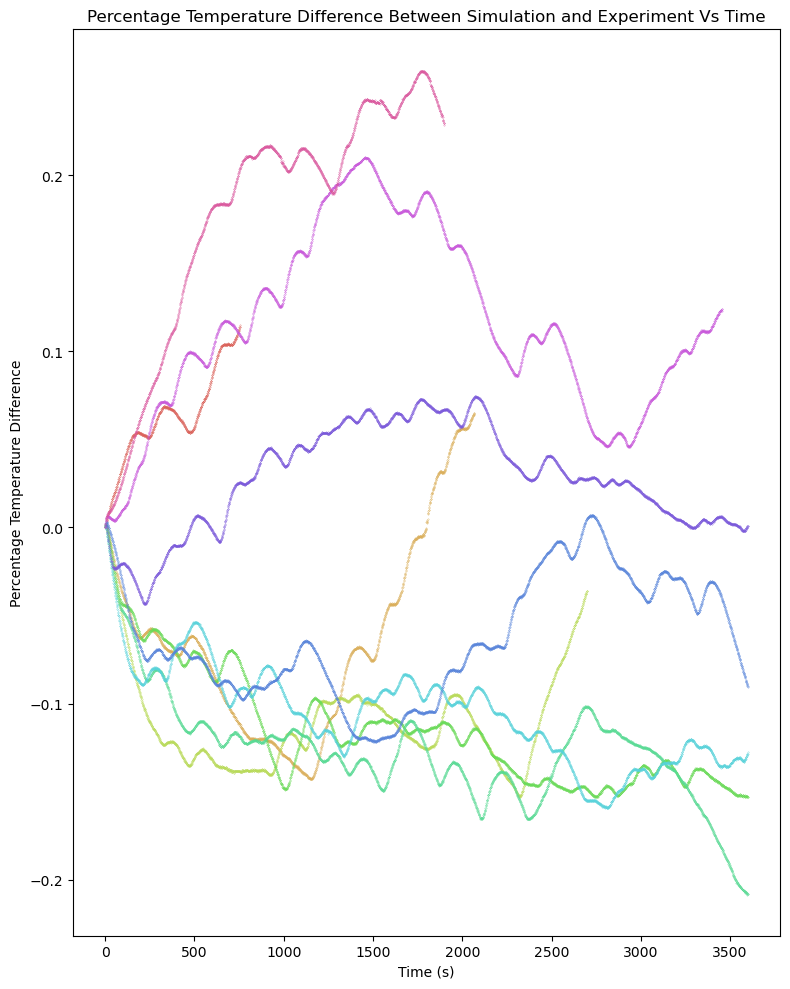

In [124]:
tempInterpListsS = []
percentDiffSE = []
totPercentDiffSE = []
for i in range(0, len(outputList)):
    interpS = interp1d(results_S[i][0], results_S[i][1][:-1]) #want to interpolate the simulation
    tempInterpS = []
    for j in range(0, len(time_E[i])):#interpolate for every experimental time stamp
        tempInterpS.append(interpS(time_E[i][j]))
    tempInterpListsS.append(tempInterpS)#add reselt for list of lists for each output
    percentDiffSE.append(100*(np.array(tempInterpListsS[i]) - np.array(temp_E[i]))/(0.5*(np.array(tempInterpListsS[i]) + np.array(temp_E[i]))))
    totPercentDiffSE.append(100*(sum(np.array(tempInterpListsS[i])) - sum(np.array(temp_E[i])))/(0.5*(sum(np.array(tempInterpListsS[i])) + sum(np.array(temp_E[i])))))
fig4, ax4 = plt.subplots(figsize=(8,10))
ax4 = plt.gca()
ax4.set_prop_cycle('color', colors)
for i in range(0, len(outputList)):
    ax4.scatter(time_E[i], percentDiffSE[i], label=str(round(outputList[i],2))+'%', s=0.05)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Percentage Temperature Difference')
ax4.set_title('Percentage Temperature Difference Between Simulation and Experiment Vs Time')
#ax4.legend(markerscale=10) 

plt.tight_layout()
plt.show()

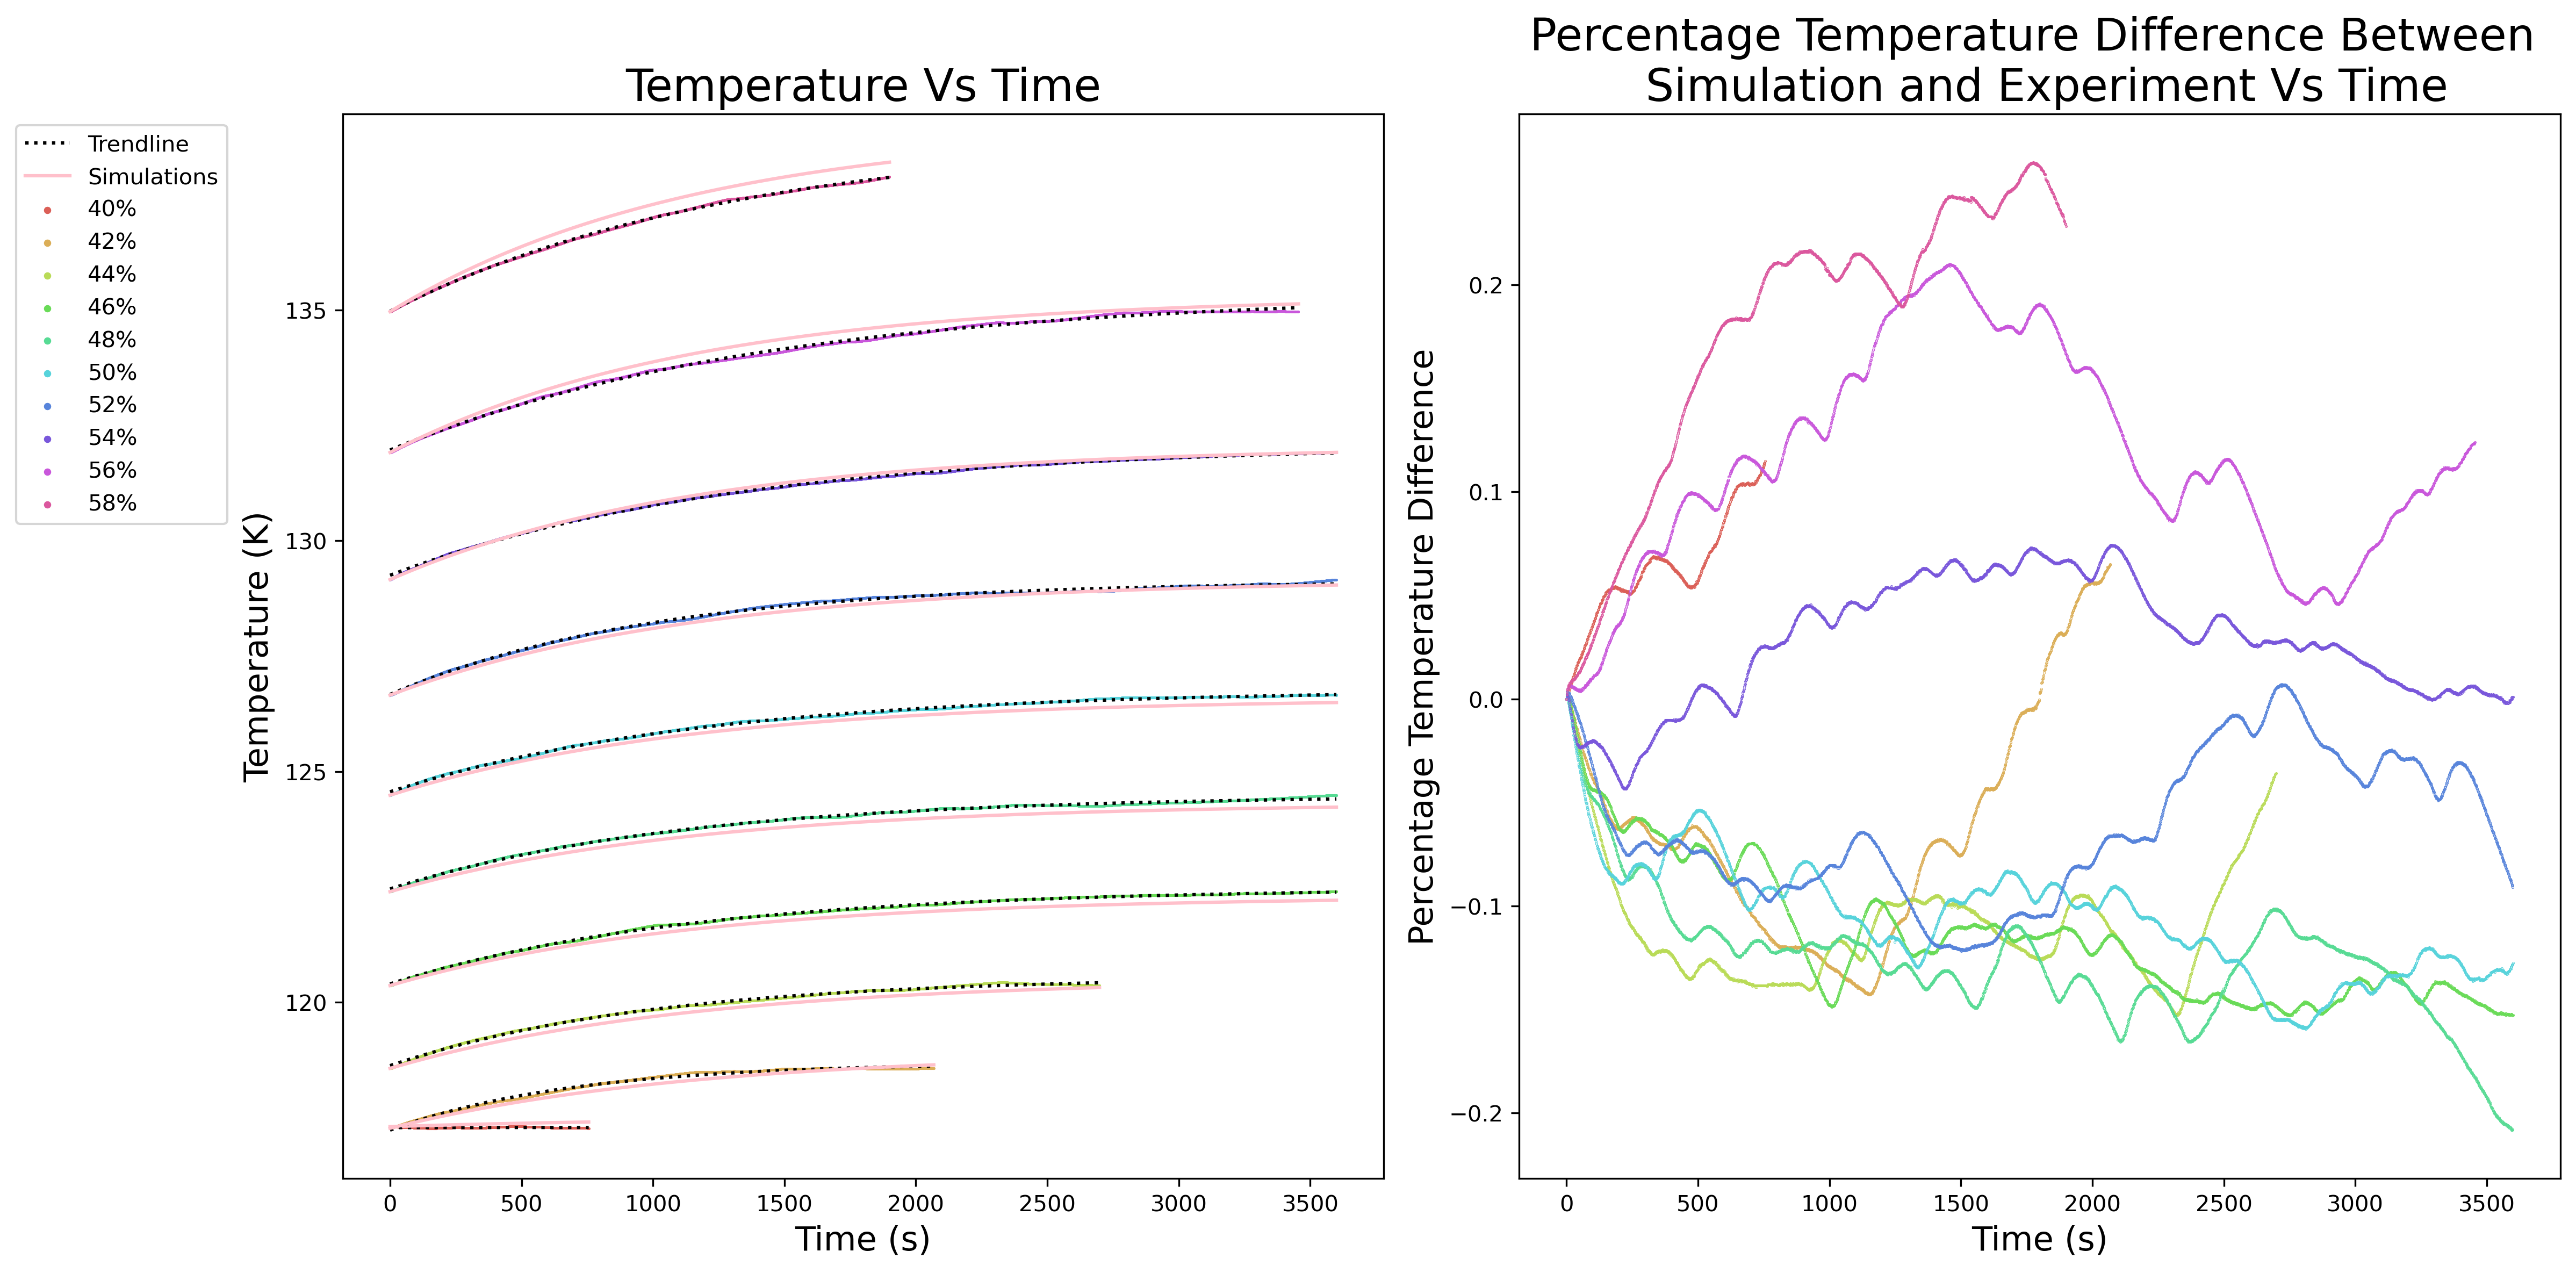

In [125]:
fig5, ax5 = plt.subplots(1, 2, figsize=(16,8), dpi=300)
#ax5[0] = plt.gca()
ax5[0].set_title('Temperature Vs Time', fontsize=20)
ax5[0].set_xlabel('Time (s)', fontsize=15)
ax5[0].set_ylabel('Temperature (K)', fontsize=15)
ax5[1].set_xlabel('Time (s)', fontsize=15)
ax5[1].set_ylabel('Percentage Temperature Difference', fontsize=15)
ax5[1].set_title('Percentage Temperature Difference Between \n Simulation and Experiment Vs Time', fontsize=20)

results_S = []
colors = sns.color_palette('hls', len(outputList))
ax5[0].set_prop_cycle('color', colors)
ax5[1].set_prop_cycle('color', colors)
for i in range(0, len(outputList)):
    #[T_Ki, taui, T0i], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i])
    #tempFit_E.append(fo(time_E[i], T_K[i], tau[i], T0[i])) 
    #results_S.append(runSim(T0[i], time_E[i][-1], finalTemp[i], hAoverCth))
    results_S.append(runSim(temp_E[i][0], time_E[i][-1], outputList[i], hAoverCth))

    if i == 0:
        ax5[0].plot(time_E[i], tempFit_E[i], color='black', linestyle=':', 
                 label='Trendline')
    else:
        ax5[0].plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    
    if i == 0:
        ax5[0].plot(results_S[i][0], results_S[i][1][:-1], color='pink',
                 label='Simulations')
    else:
        ax5[0].plot(results_S[i][0], results_S[i][1][:-1], color='pink')
        
    ax5[0].scatter(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%', s=0.05)
    ax5[1].scatter(time_E[i], percentDiffSE[i], s=0.05)#, label=str(round(outputList[i],2))+'%')
ax5[0].legend(bbox_to_anchor=(-0.1, 1), markerscale=10, fontsize=10)
plt.tight_layout()
plt.show()

In [127]:
### FITTING RESULTS
percentDiffAll = []
percentRMSAll = 0
for i in range(0, len(outputList)):
    percentDiffAll.extend(percentDiffSE[i])
avgPercentRMS = np.sqrt(np.mean(np.square(np.array(percentDiffAll))))
print("min error: ", min(np.array(percentDiffAll)), "max error: ", max(np.array(percentDiffAll)))
print("average error: ", avgPercentRMS)

min error:  -0.208359380349228 max error:  0.25930648397662154
average error:  0.11138046135382473


In [75]:
def plotTemperature(time, setpoint, temp):
    fig5 = plt.figure()
    ax5 = plt.gca()
    #plt.axhline(y=target, color='black')
    plt.plot(time, temp[:-1], label='temp', color='tab:purple')
    plt.plot(time, setpoint[:-1], label='setpoint', color='black', linestyle=':')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.legend(loc='best')
    plt.title('Temperature over time')

def plotController(controlTime, P_out, I_out, D_out, PID_out, duty):
    fig6, ax6 = plt.subplots()
    ax6 = plt.gca()
    plt.plot(controlTime, P_out, label='P output')
    plt.plot(controlTime, I_out, label='I output')
    #plt.plot(controlTime, D_out, label='D_out')
    plt.plot(controlTime, PID_out, label='PI output')
    plt.plot(controlTime, duty, label='Heater % output')
    plt.xlabel('Time(s)')
    plt.ylabel('Output')
    plt.legend(loc='best')
    plt.title("Controller output over time")

def plotError(controlTime, error, intError, gradient):
    fig7, ax7 = plt.subplots(3, 1, figsize=(8,8))
    ax7[0].plot(controlTime, error, label='error')
    ax7[0].set_ylabel('Error (K)')
    ax7[0].legend(loc='best')
    ax7[1].plot(controlTime, intError, label='Accumulated error')
    ax7[1].set_ylabel('Accumulated error (K s)')
    ax7[1].legend(loc='best')
    ax7[2].plot(controlTime[1:], gradient, label='Gradient')
    ax7[2].set_ylabel('Gradient (K/s)')
    ax7[2].legend(loc='best')
    plt.xlabel('Time (s)')

def PID(duty, error, intError, gradient_PID, K_P, T_I, T_D, P_out, I_out, D_out, PID_out, T_sensor, setpoint):
    error.append(setpoint[-1] - T_sensor[-1])
    P_out.append(K_P * error[-1])    
    
    #if (error[-1] <= 1) and (P_out[-1] <= 60.0):
    if len(intError) == 0:
        intError.append(error[-1])
    else:
        intError.append(intError[-1] + error[-1])
    #else:
        #intError.append(0.0)
    I_out.append((K_P/T_I) * intError[-1])
        
    if len(T_sensor) >= 2:
        gradient_PID.append((T_sensor[-1] - T_sensor[-2]) / controlFreq)
        D_out.append(-(K_P*T_D) * gradient_PID[-1])
    #else:
    #    D_out.append(0.0)
    #if len(gradient_PID) > 0:
    #    D_out.append(-(K_P*T_D) * gradient_PID[-1])
    PID_out.append(P_out[-1] + I_out[-1] + D_out[-1])
    if PID_out[-1] > 60.0:
        duty.append(60.0)
    elif PID_out[-1] <= 0:
        duty.append(0.0)
    else:
        duty.append(PID_out[-1])
    return duty

def runSimPID(dt, T0_PID, K_P, T_I, T_D):
    time = [] #time list
    temp = [T0_PID] #Average block temp under heater
    gradient = [] #Change in temperature over time
    
    ###PID
    controlTime = []
    T_sensor = [] #Temperature that sensor is reading
    setpoint = [T0_PID]
    #setpoint = [130]
    duty = []
    error = []
    gradient_PID = []
    intError = []
    P_out = []
    I_out = []
    D_out = [0]
    PID_out = []
    
    targetSPIndex = None
    targetMet = False
    targetIndex = None
    i = 0
    while i <= steps:
        if len(time) == 0:
            time.append(0.0)
        else:
            #Rounding avoids accumulated rounding errors from python
            time.append(round(time[-1]+dt,6))
        if i % controlSteps == 0: #If it's time to adjust controller
            T_sensor.append(temp[-1])
            duty = PID(duty, error, intError, gradient_PID, K_P, T_I, T_D, 
                       P_out, I_out, D_out, PID_out, T_sensor, setpoint)
            controlTime.append(time[-1])
            #duty.append(60.0)
        if setpoint[-1] >= target - rampRate*dt:
            setpoint.append(target)
            #if targetSPIndex == None:
            #    targetSPIndex = i
            #    print(targetSPIndex)
        else:
            setpoint.append(setpoint[-1] + rampRate * dt)
            #setpoint.append(target)         
        if (temp[-1] >= target) and (targetMet == False):
            targetIndex = i
            targetMet = True
            #print(targetIndex)
        DeltaTemp = hAoverCth * (fitFinalTemp(duty[-1], TK0, rate) - temp[-1]) * dt   
        temp.append(temp[-1] + DeltaTemp*dt)
        if len(temp) >= 2:
            gradient.append((temp[-1] - temp[-2]) / dt)
        #if ((time[-1].is_integer() == True) 
        #    and (int(time[-1]) % 60 == 0)):
        #    #print simulation time
        #    hours = int(time[-1]//(60*60))
        #    minutes = int(time[-1]/60 - hours * 60)
        #    if minutes < 10:
        #        minutes = str(0) + str(minutes)
        #    if hours < 10:
        #        hours = str(0) + str(hours)
        #    timeStamp = str(hours) + ':' + str(minutes)
        #    #print(timeStamp, end='\r')
        i += 1
    simResults = [time, temp, setpoint, gradient]
    PIDResults = [controlTime, P_out, I_out, D_out, PID_out, duty, error, intError, gradient_PID]
    #errorRMS = np.sqrt(np.mean(np.square(np.array(temp) - np.array(setpoint))))
    errorRMS = np.sqrt(np.mean(np.square(np.array(temp[targetIndex:]) 
                                         - np.array(setpoint[targetIndex:]))))
    stdDev = np.std(np.array(temp) - np.array(setpoint))
    return [errorRMS, stdDev, simResults, PIDResults]

def optimizeParameters():
    best_error = float('inf')
    best_params = None
    # Define the range of paraeter values to search
    #K_P_values = np.linspace(5, 20, 10)
    K_P_values = [25.2]
    #T_I_values = np.linspace(1200, 2000, 10)
    T_I_values = [777]
    #T_D_values = np.linspace(0.01, 5, 10)
    T_D_values = [0]
    counter = 1
    for K_P in K_P_values:
        for T_I in T_I_values:
            for T_D in T_D_values:
                # Run the simulation with the current parameter values
                errorRMS, stdDev, simResults, PIDResults = runSimPID(dt, T0_PID, K_P, T_I, T_D)
                print(counter, round(K_P,2), round(T_I,2), round(T_D,2), errorRMS, end='\r')
                counter += 1
                #print("errorRMSstab: ", errorRMSstab)
                #Check if the current parameter values yield a better result
                if errorRMS < best_error:
                    best_error = errorRMS
                    best_params = (K_P, T_I, T_D)
                #if stdDev < best_error:
                #    best_error = stdDev
                #    best_params = (K_P, T_I, T_D)
    return best_params

In [116]:
%matplotlib inline
run_PID = '4' #which no. run to analyse
path_PID = 'Results/' #path of file
runfile_PID = 'PIDdata' + str(run_PID) + '.csv'
pathRunfile = path_PID + runfile_PID
dataList_PID = readFile(pathRunfile) #read file
dataList_PID.pop(0)
dataArr_PID = np.array(dataList_PID).T
time_PID = list(map(float, dataArr_PID[0]))
temp_PID = list(map(float, dataArr_PID[1]))
setpoint_PID = list(map(float, dataArr_PID[2]))
M_out_PID = list(map(float, dataArr_PID[3]))
P_out_PID = list(map(float, dataArr_PID[4]))
I_out_PID = list(map(float, dataArr_PID[5]))
D_out_PID = list(map(float, dataArr_PID[6]))
PID_out_PID = list(map(float, dataArr_PID[7]))
error_PID = list(map(float, dataArr_PID[8]))
intError_PID = list(map(float, dataArr_PID[9]))
gradient_PID = list(map(float, dataArr_PID[10]))
for i in range (1, len(gradient_PID)):
    gradient_PID[i] = (temp_PID[i]-temp_PID[i-1])/(time_PID[i]-time_PID[i-1])

FileNotFoundError: [Errno 2] No such file or directory: 'Results/PIDdata10.csv'

In [9]:
T0_PID = temp_PID[0] #Initial temperature of system in Kelvin
dt = 1 #Time step in seconds
simTime = round(time_PID[-1]) #Time to simulate for in seconds
steps = int(simTime/dt) #amount of simulation steps
secondSteps = int(1/dt) #steps per second
minuteSteps = int(60/dt) #steps per minute
rampRate = 0.75/60 #Ramp set point 0.5 K/min
controlFreq = dt #How often to adjust output in seconds
controlSteps = int(controlFreq/dt) #Steps per adjustment
target = 130 #Set point

best_params = optimizeParameters()
K_P, T_I, T_D = best_params
errorRMS, stdDev, simResults, PIDResults = runSimPID(dt, T0_PID, K_P, T_I, T_D)
time, temp, setpoint, gradient = simResults
controlTime, P_out, I_out, D_out, PID_out, duty, error, intError, gradient_S = PIDResults
print(best_params, errorRMS)
print(len(time_PID), len(gradient_PID))

(25.2, 777, 0) 0.535579402837641
2708 2708


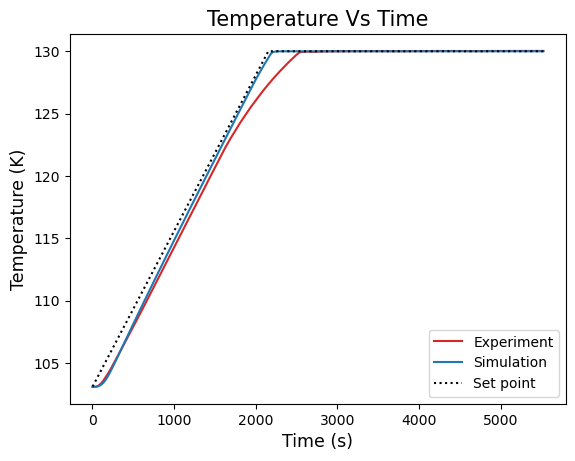

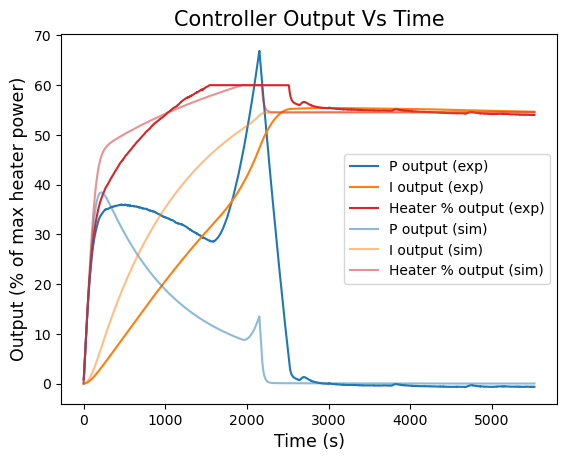

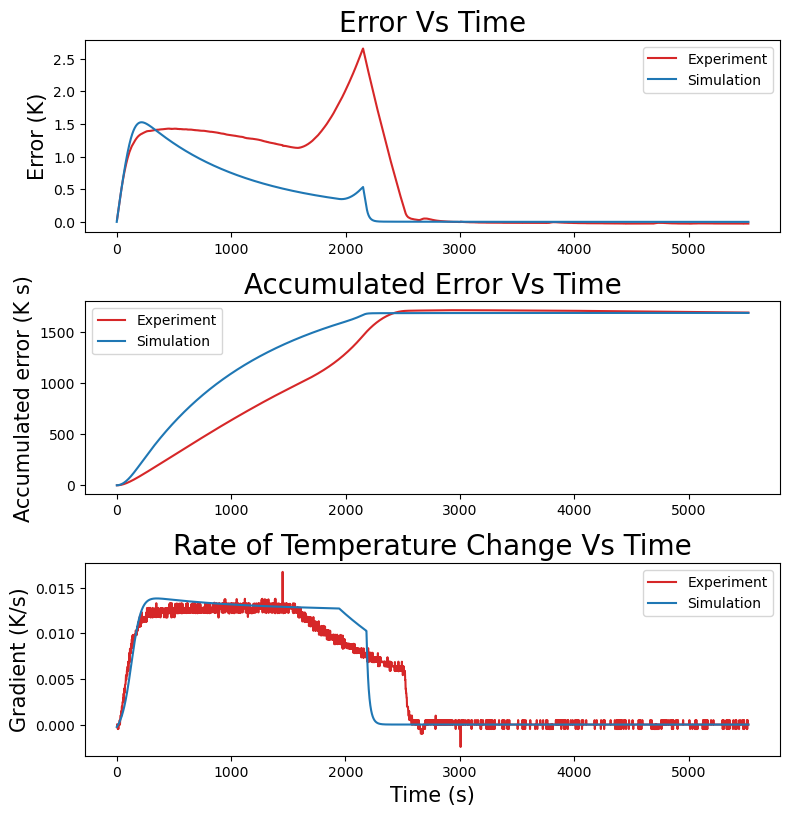

In [10]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1 = plt.gca()
#ax1.axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax1.plot(time_PID, temp_PID, label='Experiment', color='tab:red')
ax1.plot(time, temp[:-1], label='Simulation', color='tab:blue')
ax1.plot(time_PID, setpoint_PID, label='Set point', color='black', linestyle=':')
ax1.set_title('Temperature Vs Time',fontsize=15)
ax1.set_xlabel('Time (s)',fontsize=12.5)
ax1.set_ylabel('Temperature (K)',fontsize=12.5)
ax1.legend(loc='lower right')

fig2, ax2 = plt.subplots()
ax2 = plt.gca()
#ax2.axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax2.plot(time_PID, P_out_PID, color='tab:blue', label='P output (exp)')
ax2.plot(time_PID, I_out_PID, color='tab:orange', label='I output (exp)')
#ax2.plot(time_PID, PID_out_PID, color='tab:green', label='PI output (exp)')
ax2.plot(time_PID, M_out_PID, color='tab:red', label='Heater % output (exp)')
ax2.plot(controlTime, P_out, color='tab:blue', label='P output (sim)', alpha=0.5)
ax2.plot(controlTime, I_out, color='tab:orange', label='I output (sim)', alpha=0.5)
#ax2.plot(controlTime, PID_out, color='tab:green', label='PI output (sim)', alpha=0.5)
ax2.plot(controlTime, duty, color='tab:red', label='Heater % output (sim)', alpha=0.5)
ax2.set_title("Controller Output Vs Time",fontsize=15)
ax2.set_xlabel("Time (s)",fontsize=12.5)
ax2.set_ylabel("Output (% of max heater power)",fontsize=12.5)
ax2.legend()

fig3, ax3 = plt.subplots(3, 1, figsize=(8,8))
#ax3[0].axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax3[0].set_title('Error Vs Time',fontsize=20)
ax3[0].plot(time_PID, error_PID, label='Experiment', color='tab:red')
ax3[0].plot(controlTime, error, label='Simulation', color='tab:blue')
ax3[0].set_ylabel('Error (K)',fontsize=15)
ax3[0].legend(loc='best')
#ax3[1].axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax3[1].set_title('Accumulated Error Vs Time',fontsize=20)
ax3[1].plot(time_PID, intError_PID, label='Experiment', color='tab:red')
ax3[1].plot(controlTime, intError, label='Simulation', color='tab:blue')
ax3[1].set_ylabel('Accumulated error (K s)',fontsize=15)
ax3[1].legend(loc='best')
#ax3[2].axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax3[2].set_title('Rate of Temperature Change Vs Time',fontsize=20)
ax3[2].plot(time_PID[1:], gradient_PID[1:], label='Experiment', color='tab:red')
ax3[2].plot(controlTime[1:], gradient_S, label='Simulation', color='tab:blue')
ax3[2].set_ylabel('Gradient (K/s)',fontsize=15)
ax3[2].legend(loc='best')
plt.tight_layout()
plt.xlabel('Time (s)',fontsize=15)

plt.show()